# Creating a GIS layer for Finnish Health Districts


After exploring the COVID-19 [data set shared by the Helsingin Sanomat datadesk](https://github.com/HS-Datadesk/koronavirus-avoindata) which I spotted on [Twitter](https://twitter.com/EsaMakinen/status/1237007961853173761), I noticed that the boundaries of Finnish health districts (sairaanhoitopiiri) are not openly available anywhere.

This notebook walks you trought the process of creating the health district polygons based on [Statistics Finland municipality polygons](https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html) and a [list of health care districts by municipality from Kuntaliitto](https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat).

Importing required python packages:

In [35]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

### Data

- **Finnish municipalities with health district information** as an Excel spreadsheet from here: https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat
    - File `Shp_jäsenkunnat_2020.xls`, sheet `kunnat_shp_2020_ aakkosjärj.`
    - "shp" stands for "sairaanhoitopiiri" (health district in Finnish)
    
*Note: this data set does not include Åland (Ahvenanmaa). Åland municipalities are added in the later step.*

In [36]:
data = pd.read_excel("Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)

In [37]:
data.dropna(inplace=True)

In [38]:
data.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0
5,16.0,Asikkala,7.0,Päijät-Häme,HYKS,5.0


In [39]:
#Check number of rows (16 Åland municipalities are missing)
len(data)

294

The data needs some fixing and cleaning after reading the excel sheet

In [40]:
data.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'}, inplace=True)
data = data[['code','healthCareDistrict']]

In [41]:
# Truncate and convert to character string
data["code"] = data["code"].astype(int).astype('str')

# Add missing zeros to municipality codes
data["code"] = data["code"].apply(lambda x: "00" + x if len(x)==1 else x)
data["code"] = data["code"].apply(lambda x: "0" + x if len(x)==2 else x)

In [42]:
data.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


- **Municipality population counts** from kuntaliitto https://www.kuntaliitto.fi/talous/kuntien-vaesto-ja-ikarakenne
    - file `Kuntajaot ja asukasluvut kunnittain 2000-2020.xls` sheet `2020`
    - Original source: Statistics Finland

In [43]:
pop = pd.read_excel("Kuntajaot ja asukasluvut kunnittain 2000-2020.xls", sheet_name="2020", header=9)

In [44]:
pop.rename(columns={"Asukasluku":"population2020", "Kuntanro":"code"}, inplace=True)

In [45]:
# Drop no data rows from the beginning
pop.dropna(inplace=True)

# Truncate and convert to character string
pop["code"] = pop["code"].astype(int).astype('str')

# Add missing zeros to municipality codes
pop["code"] = pop["code"].apply(lambda x: "00" + x if len(x)==1 else x)
pop["code"] = pop["code"].apply(lambda x: "0" + x if len(x)==2 else x)

In [46]:
pop.head()

,code,Kunta,population2020
3,020,Akaa,16611
4,005,Alajärvi,9700
5,009,Alavieska,2573
6,010,Alavus,11544
7,016,Asikkala,8149


In [47]:
# fix data type from string to integer
pop["population2020"] = pop["population2020"].astype(int)

In [48]:
# Check length (all municipalities are included)
len(pop)

310

- **Municipality polygons** via Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html

In [49]:
# For more info, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata = gpd.read_file(url)

In [50]:
geodata.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2020,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,2020,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,2020,Alavus,Alavus,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,2020,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,2020,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


In [51]:
len(geodata)

310

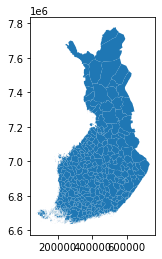

In [52]:
geodata.plot()

## Join population to municipalities

In [53]:
geodata = geodata[['kunta', 'nimi', 'name', 'geometry']].merge(pop[["code", "population2020"]], left_on="kunta", right_on="code", how="left")

In [54]:
geodata.head()

,kunta,nimi,name,geometry,code,population2020
0,005,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6...",005,9700
1,009,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7...",009,2573
2,010,Alavus,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6...",010,11544
3,016,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6...",016,8149
4,018,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6...",018,4958


## Join Health district info to the municipality polygons

In [55]:
geodata = geodata.merge(data, left_on="code", right_on="code", how="left")

In [56]:
geodata.head()

,kunta,nimi,name,geometry,code,population2020,healthCareDistrict
0,005,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6...",005,9700,Etelä-Pohjanmaa
1,009,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7...",009,2573,Pohjois-Pohjanmaa
2,010,Alavus,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6...",010,11544,Etelä-Pohjanmaa
3,016,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6...",016,8149,Päijät-Häme
4,018,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6...",018,4958,HUS


In [57]:
# Municipalities in the Åland island did not have a matching health care district in the data
geodata[geodata.healthCareDistrict.notnull()==False].name

7          Brändö
8          Eckerö
15       Finström
17          Föglö
18           Geta
24     Hammarland
58         Jomala
112      Kumlinge
122         Kökar
135       Lemland
148    Lumparland
154     Mariehamn
237       Saltvik
255      Sottunga
257          Sund
302         Vårdö
Name: name, dtype: object

In [58]:
# Update "Ahvenanmaa" as the health care district for Åland municipalities (16 municipalities in total)
geodata.loc[geodata.healthCareDistrict.notnull()==False,'healthCareDistrict'] = "Ahvenanmaa"

Check the count of municipalities per health care disctrict

In [59]:
geodata.healthCareDistrict.value_counts()

Pohjois-Pohjanmaa    29
Varsinais-Suomi      28
HUS                  24
Pirkanmaa            23
Keski-Suomi          21
Etelä-Pohjanmaa      18
Pohjois-Savo         18
Satakunta            17
Ahvenanmaa           16
Lappi                15
Pohjois-Karjala      13
Vaasa                13
Päijät-Häme          12
Kanta-Häme           11
Keski-Pohjanmaa      10
Etelä-Karjala         9
Etelä-Savo            9
Kainuu                8
Kymenlaakso           6
Länsi-Pohja           6
Itä-Savo              4
Name: healthCareDistrict, dtype: int64

## Create polygons for health care districts 

In [60]:
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict', aggfunc="sum")

In [61]:
districts.head()

,geometry,population2020
healthCareDistrict,,
Ahvenanmaa,"MULTIPOLYGON (((173277.623 6640282.925, 173136...",29789
Etelä-Karjala,"POLYGON ((595843.841 6772915.996, 592557.900 6...",128756
Etelä-Pohjanmaa,"POLYGON ((373036.311 6953044.961, 376149.768 6...",194316
Etelä-Savo,"POLYGON ((596327.952 6823806.064, 596718.363 6...",100226
HUS,"MULTIPOLYGON (((272609.681 6632304.439, 272418...",1667203


In [62]:
districts.reset_index(inplace=True)

In [63]:
districts = districts[['healthCareDistrict','population2020','geometry']]

In [64]:
districts

,healthCareDistrict,population2020,geometry
0,Ahvenanmaa,29789,"MULTIPOLYGON (((173277.623 6640282.925, 173136..."
1,Etelä-Karjala,128756,"POLYGON ((595843.841 6772915.996, 592557.900 6..."
2,Etelä-Pohjanmaa,194316,"POLYGON ((373036.311 6953044.961, 376149.768 6..."
3,Etelä-Savo,100226,"POLYGON ((596327.952 6823806.064, 596718.363 6..."
4,HUS,1667203,"MULTIPOLYGON (((272609.681 6632304.439, 272418..."
5,Itä-Savo,41060,"POLYGON ((572240.425 6898837.522, 576521.513 6..."
6,Kainuu,73061,"POLYGON ((606127.874 7081796.115, 603849.594 7..."
7,Kanta-Häme,171364,"POLYGON ((393094.362 6756355.691, 394102.316 6..."
8,Keski-Pohjanmaa,77689,"MULTIPOLYGON (((302835.219 7083897.220, 302801..."
9,Keski-Suomi,252676,"POLYGON ((439110.805 6852598.036, 439300.113 6..."


(40857.339215, 765862.479085, 6575077.820610001, 7833703.7515899995)

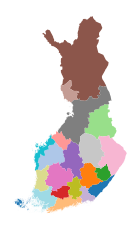

In [65]:
districts.plot(column='healthCareDistrict', scheme="equal_interval",cmap='tab20', k=20)
plt.axis('off')

In [66]:
# Write GeoJSON in original projection
districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding='utf-8')

In [67]:
# Re-project to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding='utf-8')

In [68]:
# Write population per health care district to csv
districts[['healthCareDistrict','population2020']].to_csv("healtCareDistricts_population2020.csv", index=False)